**COMPARING ESN AND XGB FOR GB DAY-AHEAD EPF WITHOUT EXOGENOUS INPUTS**


**ESN implementation for day-ahead EPF**  

**The data:**
* The data is from Nord Pool.
* The dataset reflects the day-ahead electricity prices as reported by Nord Pool
* The day-ahead electricity price used for this project is recorded every hour
* The data covers 2020-06-01 to 2024-05-31

**Importing and preprocessing**

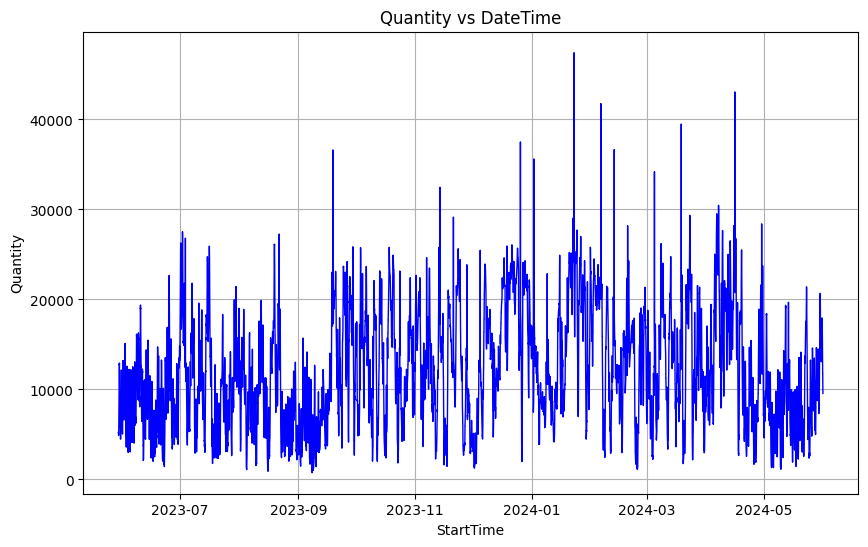

In [ ]:
# the renewable forecast data from Elexon

import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('renewables.csv')

# Ensure DateTime column is in datetime format
df['StartTime'] = pd.to_datetime(df['StartTime'])

# Group by DateTime and sum the grouped data
grouped_df = df.groupby('StartTime').sum().reset_index()

# Plot the summed values against DateTime
plt.figure(figsize=(10, 6))
plt.plot(grouped_df['StartTime'], grouped_df['Quantity'], color='blue', linewidth=1)
plt.xlabel('StartTime')
plt.ylabel('Quantity')
plt.title('Quantity vs DateTime')
plt.grid(True)
plt.show()

In [ ]:
# import data
# Uk hourly electricity prices from NORDPOOL
# For UK Daylight Saving Time, the average of two hours were used on the day clock moved backward by an hour
#  and the hour before time change was repeated on the day clock moved forward. The changes were done in the excel file before importing here.

import pandas as pd
import numpy as np
import pytz

prices = pd.read_excel('auction-prices22.xls', sheet_name='Sheet2') # Note: data dateTime in UK time
price = []
Settlement_date = []
hour = ['1', '2', '3A', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
for index, row in prices.iterrows():
    for x in hour:
        if x != '3A':
            x = int(x)
        price.append(row[x])
        Settlement_date.append(row['Date'])

prices_df = pd.DataFrame({'Settlement_date': Settlement_date, 'Price': price})
prices_df = prices_df.dropna()

# Define the start and end dates (extra 7 days added to take care of the one week lagged feature)
start_date = '2020-05-24 23:00'
end_date = '2024-05-31 22:00'

# Set the time zone for London
timezone = pytz.timezone('Europe/London')

# Generate a date range with one-hour intervals
date_range = pd.date_range(start=start_date, end=end_date, freq='H', tz=timezone)

# Convert to a list of strings in the desired format
date_list = date_range.tolist()

TS_prices = pd.DataFrame({'DateTime': date_list, 'Delivery_date': prices_df['Settlement_date'].tolist(), 'Price': prices_df['Price'].tolist()})

# Convert to datetime
TS_prices['DateTime'] = pd.to_datetime(TS_prices['DateTime'])


**Initial TS plotting**

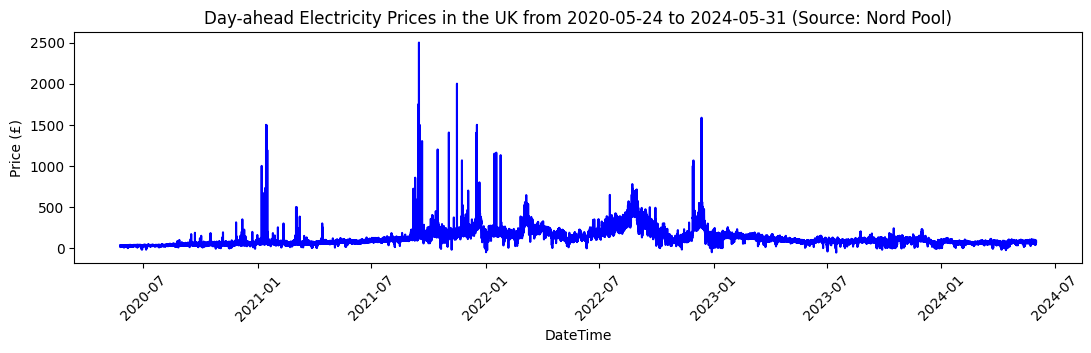

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Plotting
plt.figure(figsize=(13, 3))
plt.plot(TS_prices.copy()['DateTime'], TS_prices.copy()['Price'], color='blue')

# Label the axes
plt.xlabel('DateTime')
plt.ylabel('Price (£)')
plt.title('Day-ahead Electricity Prices in the UK from 2020-05-24 to 2024-05-31 (Source: Nord Pool)')

# Improve x-axis readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


**Non-linearity check**

**Check stationarity of the TS**

In [ ]:
# function to check stationarity
import numpy as np
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data):
    """
    Perform Augmented Dickey-Fuller test for stationarity.

    Parameters:
    - data (numpy array or list): Time series data to be tested.

    Returns:
    - A dictionary containing ADF statistic, p-value, critical values, and stationarity result.
    """
    result = {}

    # Perform Augmented Dickey-Fuller test
    adf_result = adfuller(data)

    # Extract and store results
    result['ADF Statistic'] = adf_result[0]
    result['p-value'] = adf_result[1]


    # Determine stationarity
    if adf_result[1] <= 0.05:
        result['Stationarity'] = "Stationary"
    else:
        result['Stationarity'] = "Not stationary"

    return result

In [ ]:
# check stationariy
test_stationarity(TS_prices.copy()['Price'])

{'ADF Statistic': -5.938505592565825,
 'p-value': 2.2904222281652598e-07,
 'Stationarity': 'Stationary'}

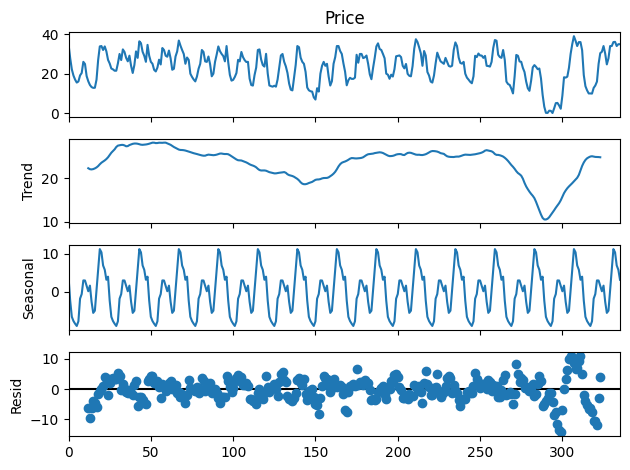

In [ ]:
# Decompose the TS to identify trends

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np

# Check seasonality of the TS
result = seasonal_decompose(TS_prices.copy()['Price'][:336], model='additive', period=24)

# Plot the decomposition
result.plot()
plt.show()

**Normalization**

In [ ]:
# Normalization and denormalization functions

import numpy as np

def normalize_tanh(column, mean=None, std=None):
    # Calculate mean and std if they are not provided
    if mean is None or std is None:
        mean = column.mean()
        std = column.std()

    # Standardize the data
    standardized = (column - mean) / std

    # Apply tanh
    normalized = np.tanh(standardized)

    return normalized, mean, std

def denormalize_tanh(normalized, mean, std):
    # Apply inverse tanh
    standardized = np.arctanh(normalized)

    # Reverse standardization
    original = standardized * std + mean
    return original

**PLOT ACF and PACF**

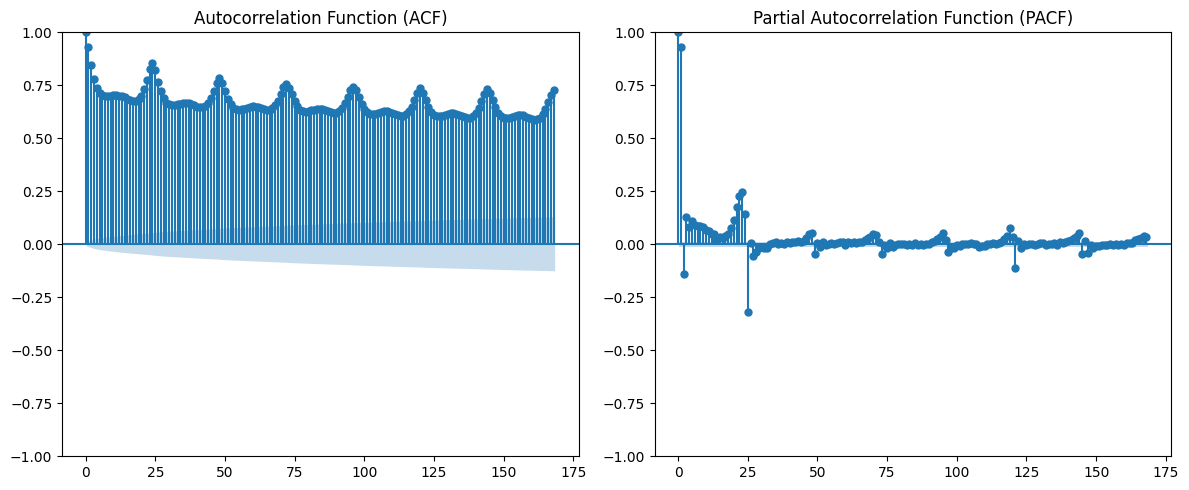

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Plot ACF
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(TS_prices['Price'].copy(), lags=168, ax=plt.gca(), title='Autocorrelation Function (ACF)')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(TS_prices['Price'].copy(), lags=168, ax=plt.gca(), title='Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


**Input and output data for ESN**

In [ ]:
# model the TS into a supervised learning dataset to have inputs and outputs
import pandas as pd
import numpy as np

# Function to create input and output vectors
def create_input_output_vectors(df):
    inputs = []
    outputs = []

    # Extract prices and reshape them into daily segments
    daily_prices = df.set_index('Delivery_date').resample('D').apply(lambda x: x['Price'].values)

    for i in range(6, len(daily_prices)-1):  # Start from the 7th day to have previous week data
        current_day_prices = daily_prices.iloc[i]
        previous_week_day_prices = daily_prices.iloc[i-1]


        # Skip if either current day or previous week day does not have 24 hours of data
        if len(current_day_prices) == 24 and len(previous_week_day_prices) == 24:
            input_vector = np.concatenate((current_day_prices, previous_week_day_prices))
            output_vector = daily_prices.iloc[i+1]  # Prices for the next day

            if len(output_vector) == 24:  # Ensure the next day has 24 hours of data
                inputs.append(input_vector)
                outputs.append(output_vector)

    return np.array(inputs), np.array(outputs)

# Generate input and output vectors
inputs, outputs = create_input_output_vectors(TS_prices.copy())

print("Input shape:", inputs.shape)
print("Output shape:", outputs.shape)

#'''Do not normalize all the dataset together to avoid test data leaking into training data'''

Input shape: (1461, 48)
Output shape: (1461, 24)


**Hyperparametrs tuning (Bayesian optimization) and validation**

In [ ]:
# instrall bayesian-optimization
!pip install bayesian-optimization

In [ ]:
import numpy as np
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from pyESN2 import ESN

# Define the function to optimize
def esn_evaluate(n_reservoir, spectral_radius, leaky_rate,  sparsity,  noise, input_scaling):
    n_reservoir = int(n_reservoir)

    # Initialize the ESN model with the chosen hyperparameters
    esn = ESN(n_inputs= 48,
              n_outputs=24,
              n_reservoir=n_reservoir,
              sparsity=   sparsity,
              spectral_radius=spectral_radius,
              noise= noise,
              leaky_rate=leaky_rate,
              input_scaling = input_scaling,
              random_state= 91)

    window_size = 730  # Two years data for training (2 x 365)

    # Use global variables inside the function
    #global X_val, inputs, outputs
    global  inputs, outputs

    losses = []

    for i in range(365): #validate on one year data
        # Create rolling window for training and validation data
        input_train = inputs[i:i + window_size]
        output_train = outputs[i:i + window_size]
        input_val = inputs[730 + i: 730 + i + 1]
        output_val = outputs[730 + i: 730 + i + 1]

        #normalize
        #use train data to get mean and std
        all_train, mean, std = normalize_tanh(TS_prices.copy()['Price'][(i*24) : (i*24) + 17688])

        #normalize the rolling train and val datasets
        input_train, mean, std = normalize_tanh(input_train, mean= mean, std= std)
        output_train, mean, std = normalize_tanh(output_train, mean= mean, std= std)
        input_val, mean, std = normalize_tanh(input_val, mean= mean, std= std)
        output_val, mean, std = normalize_tanh(output_val, mean= mean, std= std)

        # Train the ESN model
        esn.fit(input_train, output_train)

        # Make predictions
        y_pred = esn.predict(input_val)

        # Calculate the loss (e.g., Mean Squared Error)
        loss = mean_squared_error(output_val, y_pred)
        losses.append(loss)

    return -np.mean(losses)

In [ ]:
# Bayesian optimization for ESN hyperparameters:

# Define the parameter bounds
param_bounds = {
    'n_reservoir': (50, 1000),
    'spectral_radius': (0.1,  0.99),
    'sparsity': (0.1, 1.0),
    'noise': (0, 0.01),
    'input_scaling': (0.01, 1.0),
    'leaky_rate': (0.1, 1.0)
}

# Perform Bayesian Optimization
optimizer = BayesianOptimization(f=esn_evaluate, pbounds=param_bounds, random_state=91)
optimizer.maximize(init_points=3, n_iter=50) # more iterations done initially, but takes time.

# Retrieve the best parameters
best_params = optimizer.max['params']
print(f"Best Parameters: {best_params}")



In [ ]:
best_params = {'input_scaling': 1.0,
 'leaky_rate': 0.1,
 'n_reservoir': 50.0,
 'noise': 0.007125789486670557,
 'sparsity': 0.9,
 'spectral_radius': 0.1}


**Fitting the model**

In [ ]:
# build the final model using the best parameters
esn = ESN(n_inputs=48,
          n_outputs=24,
          input_scaling = best_params['input_scaling'],
          n_reservoir=int(best_params['n_reservoir']),
          sparsity = best_params['sparsity'],
          spectral_radius = best_params['spectral_radius'],
          noise = best_params['noise'],
          leaky_rate = best_params['leaky_rate'],
          random_state= 91)

**Testing phase: EPF using the model with optimal hyperparameters**

In [ ]:
# testing / EPF for one year.
preds_test = []
for i in range(0, len(inputs[1095:])):

  #normlize
  input_train = inputs[365 + i: i + 1095]
  output_train = outputs[365 + i: i + 1095]
  input_test = inputs[1095 + i: 1095 + i + 1]

  #normalize
  #use train data to get mean and std
  all_train, mean, std = normalize_tanh(TS_prices.copy()['Price'][(i*24) + 8760 : (i*24) + 26448])

  #normalize the rolling train and test datasets
  input_train, mean, std = normalize_tanh(input_train, mean= mean, std= std)
  output_train, mean, std = normalize_tanh(output_train, mean= mean, std= std)
  input_test, mean, std = normalize_tanh(input_test, mean= mean, std= std)

  # Train the best model on 2 years rolling train data
  esn.fit(input_train, output_train)

  # Make predictions
  prediction = esn.predict(input_test)

  # denormalize
  prediction = denormalize_tanh(prediction, mean, std)

  #append
  preds_test.append(prediction)

**Dataframe for the real value and predicted values (Naive, XGB, ESN)**

In [ ]:
# import XGB and Naive results
result = pd.read_excel('result10_08.xlsx')

# create a dataframe
result['ESN_Prediction'] = pd.DataFrame({ 'ESN_Prediction': np.array(preds_test).flatten()})

#include settlement date
result['DateTime'] = result['DateTime'].dt.tz_localize('Europe/London', ambiguous='infer') # Handle ambiguous times
result = pd.merge(result, TS_prices[['DateTime','Delivery_date']], on='DateTime', how='inner')

# drop column Unnamed: 0
#result = result.drop(['Unnamed: 0'], axis=1)


**Results and Analysis**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Group by month and plot
for month, group in result.groupby(result['Month']):
    plt.figure(figsize=(12, 6))
    plt.plot(group['DateTime'], group['Actual_price'], label='Actual Price', color='green', linewidth=1.5)
    plt.plot(group['DateTime'], group['XGB_Prediction'], label='XGBoost Prediction', color='orange', linestyle='--', linewidth=1.5)
    plt.plot(group['DateTime'], group['Naive_Prediction'], label='Naive Prediction', color='purple', linestyle=':', linewidth=1.5)
    plt.plot(group['DateTime'], group['ESN_Prediction'], label='ESN Prediction', color='brown', linestyle='-.', linewidth=1.5)

    plt.title(f'Actual vs Predicted Prices for {month.strftime("%B %Y")}')
    plt.xlabel('DateTime')
    plt.ylabel('Price (£)')
    plt.legend()
    #plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

**Plotting the real vs predicted results**

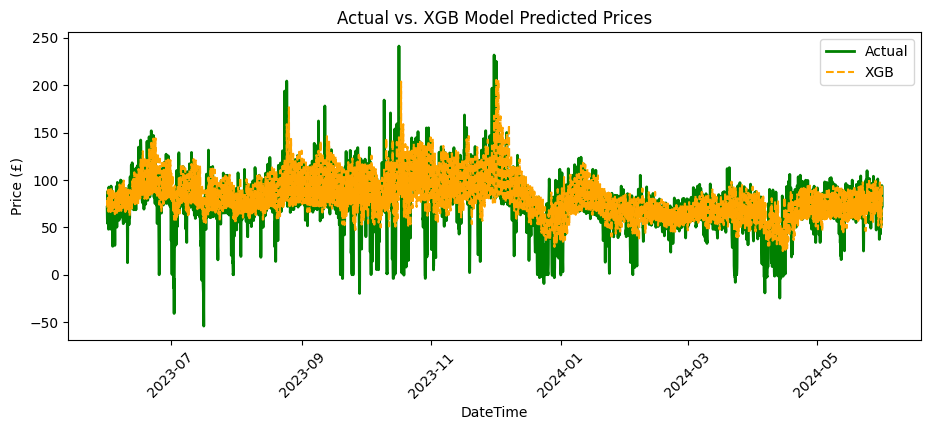

In [ ]:
# Plotting

X = pd.to_datetime(result['DateTime'].copy())

plt.figure(figsize=(11, 4))

plt.plot(X, result['Actual_price'], label = 'Actual', color='green', linewidth=2.0)

plt.plot(X, result['XGB_Prediction'], label = 'XGB', color='orange', linestyle='--', linewidth=1.5)



# Label the axes
plt.xlabel('DateTime')
plt.ylabel('Price (£)')
plt.title('Actual vs. XGB Model Predicted Prices')
plt.legend(loc='best')

# Improve x-axis readability
plt.xticks(rotation=45)  # Rotating by -90 degrees might make the labels overlap

# Display the plot
plt.show()

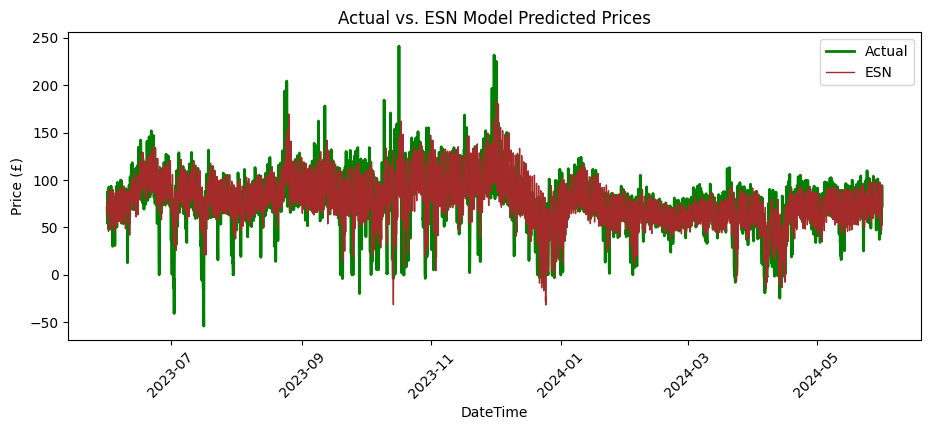

In [ ]:
# Plotting

X = pd.to_datetime(result['DateTime'].copy())

plt.figure(figsize=(11, 4))

plt.plot(X, result['Actual_price'], label = 'Actual', color='green', linewidth=2.0)
plt.plot(X, result['ESN_Prediction'], label = 'ESN', color='brown', linewidth=1.0)



# Label the axes
plt.xlabel('DateTime')
plt.ylabel('Price (£)')
plt.title('Actual vs. ESN Model Predicted Prices')
plt.legend(loc='best')

# Improve x-axis readability
plt.xticks(rotation=45)  # Rotating by -90 degrees might make the labels overlap

# Display the plot
plt.show()

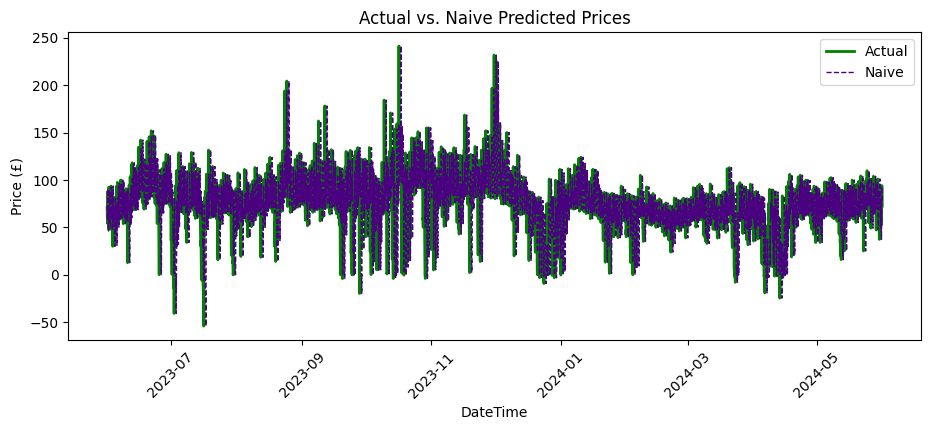

In [ ]:
# Plotting

X = pd.to_datetime(result['DateTime'].copy())

plt.figure(figsize=(11, 4))

plt.plot(X, result['Actual_price'], label = 'Actual', color='green', linewidth=2.0)
plt.plot(X, result['Naive_Prediction'], label = 'Naive', color='indigo', linestyle='--', linewidth=1.0)


# Label the axes
plt.xlabel('DateTime')
plt.ylabel('Price (£)')
plt.title('Actual vs. Naive Predicted Prices')
plt.legend(loc='best')

# Improve x-axis readability
plt.xticks(rotation=45)  # Rotating by -90 degrees might make the labels overlap

# Display the plot
plt.show()

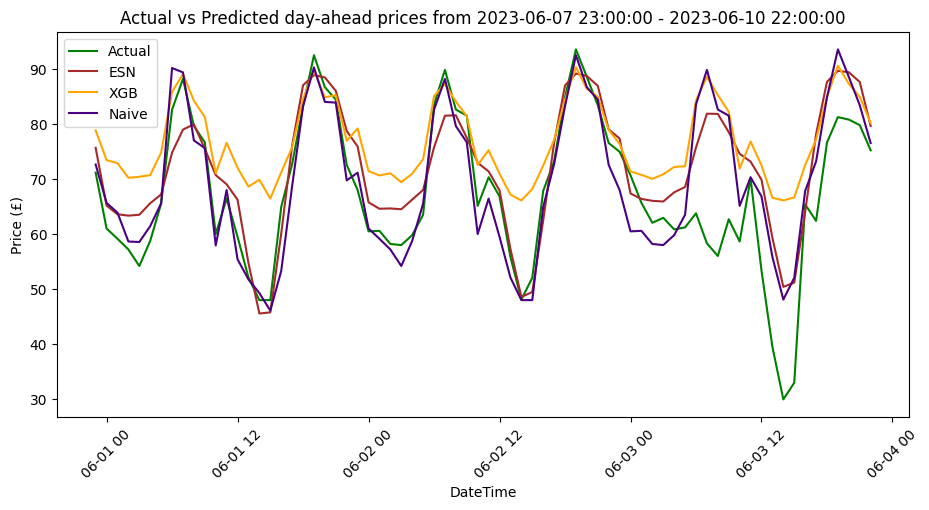

In [ ]:
# plot 3 days data
# Plotting
X = X[:72]

plt.figure(figsize=(11, 5))
plt.plot(X, result['Actual_price'][:72], label = 'Actual', color='green')
plt.plot(X, result['ESN_Prediction'][:72], label = 'ESN', color='brown')
plt.plot(X, result['XGB_Prediction'][:72], label = 'XGB', color='orange')
plt.plot(X, result['Naive_Prediction'][:72], label = 'Naive', color='indigo')

# Label the axes
plt.xlabel('DateTime')
plt.ylabel('Price (£)')
plt.title('Actual vs Predicted day-ahead prices from 2023-06-07 23:00:00 - 2023-06-10 22:00:00')
plt.legend(loc='best')

# Improve x-axis readability
plt.xticks(rotation=45)  # Rotating by -90 degrees might make the labels overlap

# Display the plot
plt.show()

**Model performance evaluation on one year test data**

In [ ]:
# function to calculate MAPE

def MAPE(df, actual_col, model_col, date_col='Delivery_date'):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) for a single prediction model
    using the daily average price as the denominator to avoid errors due to zero actual prices.
    """
    # Ensure the date column is in datetime format
    df[date_col] = pd.to_datetime(df[date_col])

    # Calculate daily average prices
    daily_avg_prices = df.groupby(date_col)[actual_col].mean().reset_index()
    daily_avg_prices.rename(columns={actual_col: 'Daily_Avg_Price'}, inplace=True)

    # Merge daily average prices back into the original DataFrame
    df = pd.merge(df, daily_avg_prices, on=date_col)

    # Calculate the Absolute Percentage Error (APE) for each hour
    df['APE'] = np.abs(df[actual_col] - df[model_col]) / df['Daily_Avg_Price']

    # Calculate the Mean Absolute Percentage Error (MAPE)
    total_ape_sum = df['APE'].sum()
    total_hours = df.shape[0]
    mape = (total_ape_sum / total_hours) * 100

    return mape

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

'''XGB'''
# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(result['Actual_price'], result['XGB_Prediction'])

# Calculate MAPE (Mean Absolute Percentage Error)
mape = MAPE(result, 'Actual_price', 'XGB_Prediction')


# Calculate sMAPE (Symmetric Mean Absolute Percentage Error)
smape = np.mean(np.abs(result['Actual_price'] - result['XGB_Prediction']) / (np.abs(result['Actual_price']) + np.abs(result['XGB_Prediction']))) * 100

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(result['Actual_price'], result['XGB_Prediction']))


''' Naive'''
# Calculate MAE (Mean Absolute Error)
mae_naive = mean_absolute_error(result['Actual_price'], result['Naive_Prediction'])

# Calculate MAPE (Mean Absolute Percentage Error)
mape_naive = MAPE(result, 'Actual_price', 'Naive_Prediction')


# Calculate sMAPE (Symmetric Mean Absolute Percentage Error)
smape_naive = np.mean(np.abs(result['Actual_price'] - result['Naive_Prediction']) / (np.abs(result['Actual_price']) + np.abs(result['Naive_Prediction']))) * 100

# Calculate RMSE (Root Mean Squared Error)
rmse_naive = np.sqrt(mean_squared_error(result['Actual_price'], result['Naive_Prediction']))


'''ESN'''
# Calculate MAE (Mean Absolute Error)
mae_esn = mean_absolute_error(result['Actual_price'], result['ESN_Prediction'])

# Calculate MAPE (Mean Absolute Percentage Error)
mape_esn = MAPE(result, 'Actual_price', 'ESN_Prediction')


# Calculate sMAPE (Symmetric Mean Absolute Percentage Error)
smape_esn = np.mean(np.abs(result['Actual_price'] - result['ESN_Prediction']) / (np.abs(result['Actual_price']) + np.abs(result['ESN_Prediction']))) * 100

# Calculate RMSE (Root Mean Squared Error)
rmse_esn = np.sqrt(mean_squared_error(result['Actual_price'], result['ESN_Prediction']))


# Create a DataFrame to present the results
results = pd.DataFrame({
    'Metric': ['MAE', 'MAPE', 'sMAPE', 'RMSE'],
    'XGBOOST': [mae, mape, smape, rmse],
    'Naive': [mae_naive, mape_naive, smape_naive, rmse_naive],
    'ESN': [mae_esn, mape_esn, smape_esn, rmse_esn]
})

# Print the results table
print(results.round(3))

  Metric  XGBOOST   Naive     ESN
0    MAE   12.788  13.984  11.300
1   MAPE   31.728  27.583  24.941
2  sMAPE   11.462  14.236  10.843
3   RMSE   19.180  21.560  16.129


In [ ]:
# Monthly model evaluation
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Add a 'Month' column to the DataFrame
result['Month'] = result['Delivery_date'].dt.to_period('M')

# Group by Month
monthly_groups = result.groupby('Month')

# Initialize lists to store results
metrics_list = []

# Iterate over each month group
for month, group in monthly_groups:
    '''XGB'''
    # Calculate MAE
    mae = mean_absolute_error(group['Actual_price'], group['XGB_Prediction'])

    # Calculate MAPE
    mape = MAPE(group, 'Actual_price', 'XGB_Prediction')

    # Calculate sMAPE
    smape = np.mean(np.abs(group['Actual_price'] - group['XGB_Prediction']) /
                    (np.abs(group['Actual_price']) + np.abs(group['XGB_Prediction']))) * 100

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(group['Actual_price'], group['XGB_Prediction']))

    ''' Naive'''
    # Calculate MAE
    mae_naive = mean_absolute_error(group['Actual_price'], group['Naive_Prediction'])

    # Calculate MAPE
    mape_naive = MAPE(group, 'Actual_price', 'Naive_Prediction')

    # Calculate sMAPE
    smape_naive = np.mean(np.abs(group['Actual_price'] - group['Naive_Prediction']) /
                          (np.abs(group['Actual_price']) + np.abs(group['Naive_Prediction']))) * 100

    # Calculate RMSE
    rmse_naive = np.sqrt(mean_squared_error(group['Actual_price'], group['Naive_Prediction']))

    '''ESN'''
    # Calculate MAE
    mae_esn = mean_absolute_error(group['Actual_price'], group['ESN_Prediction'])

    # Calculate MAPE
    mape_esn = MAPE(group, 'Actual_price', 'ESN_Prediction')

    # Calculate sMAPE
    smape_esn = np.mean(np.abs(group['Actual_price'] - group['ESN_Prediction']) /
                        (np.abs(group['Actual_price']) + np.abs(group['ESN_Prediction']))) * 100

    # Calculate RMSE
    rmse_esn = np.sqrt(mean_squared_error(group['Actual_price'], group['ESN_Prediction']))

    # Append metrics for this month to the list
    metrics_list.append({
        'Month': str(month),
        'Metric': 'MAE',
        'Naive': mae_naive,
        'XGBOOST': mae,
        'ESN': mae_esn
    })

    metrics_list.append({
        'Month': str(month),
        'Metric': 'RMSE',
        'Naive': rmse_naive,
        'XGBOOST': rmse,
        'ESN': rmse_esn
    })

    metrics_list.append({
        'Month': str(month),
        'Metric': 'MAPE',
        'Naive': mape_naive,
        'XGBOOST': mape,
        'ESN': mape_esn
    })

    # metrics_list.append({
    #     'Month': str(month),
    #     'Metric': 'sMAPE',
    #     'XGBOOST': smape,
    #     'Naive': smape_naive,
    #     'ESN': smape_esn
    # })



# Convert the list of metrics into a DataFrame
monthly_results = pd.DataFrame(metrics_list)


In [ ]:
monthly_results

,Month,Metric,Naive,XGBOOST,ESN
0,2023-06,MAE,9.718403,9.534545,9.363640
1,2023-06,RMSE,15.053591,13.888151,13.443264
2,2023-06,MAPE,12.010182,12.277524,11.706092
3,2023-07,MAE,19.512110,16.354668,15.125345
4,2023-07,RMSE,29.041614,26.474861,22.272397
5,2023-07,MAPE,58.799188,82.624005,66.801065
6,2023-08,MAE,11.804382,9.916650,9.405284
7,2023-08,RMSE,16.786542,14.212414,13.814248
8,2023-08,MAPE,15.440232,12.944006,12.134241
9,2023-09,MAE,14.515292,12.009375,12.332235


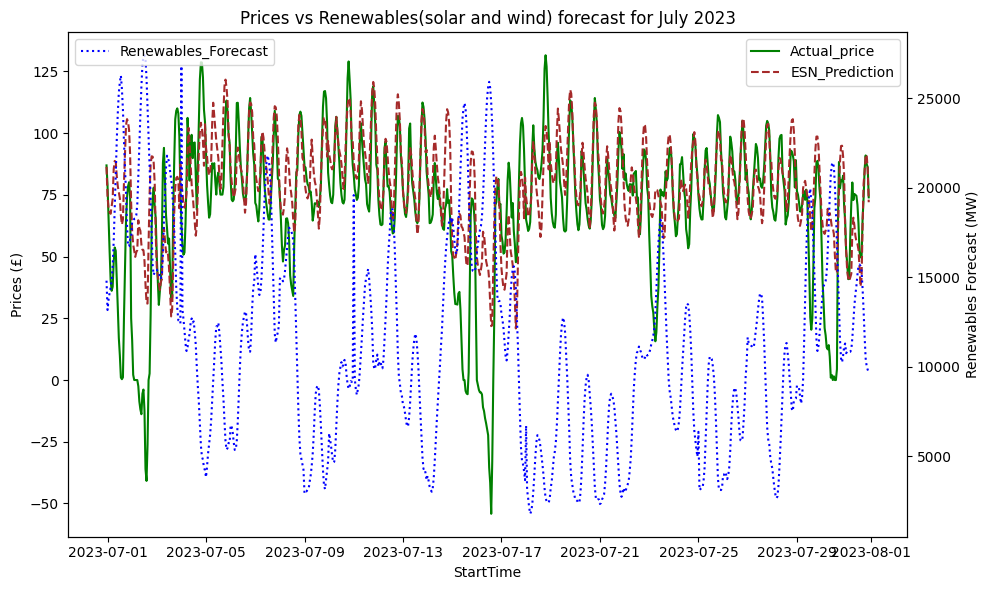

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file into a DataFrame
julyData = pd.read_csv('julyData.csv')


# Ensure 'dateTime' column is in datetime format
julyData['StartTime'] = pd.to_datetime(julyData['StartTime'])

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the first two columns (ave and qty) on the left y-axis
ax1.plot(julyData['StartTime'], julyData['Actual_price'], label='Actual_price', color='green')
ax1.plot(julyData['StartTime'], julyData['ESN_Prediction'], label='ESN_Prediction', color='brown', linestyle='--')
ax1.set_xlabel('StartTime')
ax1.set_ylabel('Prices (£)')
ax1.legend(loc='upper right')

# Create a second y-axis on the right side for the 'ren' column
ax2 = ax1.twinx()
ax2.plot(julyData['StartTime'], julyData['Renewables'], label='Renewables_Forecast', color='blue', linestyle=':', linewidth=1.5)
ax2.set_ylabel('Renewables Forecast (MW)')
ax2.legend(loc='upper left')

# Add a title and show the plot
plt.title('Prices vs Renewables(solar and wind) forecast for July 2023')
plt.tight_layout()

#make x-axis label slant
plt.xticks(rotation=45)
plt.show()


